# Using our Data
Let's go through the process using our audio data. 

In [2]:
# Config
import yaml
import pickle
import os 
import pandas as pd
import numpy as np
import sounddevice as sd
import soundfile as sf
import librosa
from IPython.display import clear_output, Audio
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [2]:
with open('XX Data/config.yaml', 'r') as file:
    inputs = yaml.safe_load(file)

#phoneme_files = sorted([file for file in os.listdir(inputs['phoneme_files']) if not file.startswith('.')])
#wav_files = sorted([file for file in os.listdir(inputs['wav_files']) if not file.startswith('.')])
#word_files = sorted([file for file in os.listdir(inputs['word_files']) if not file.startswith('.')])

test_wav_files = sorted([file for file in os.listdir(inputs['test_wav_files']) if not file.startswith('.')])
test_fake_wav_files = sorted([file for file in os.listdir(inputs['test_fake_files']) if not file.startswith('.')])
test_word_files = sorted([file for file in os.listdir(inputs['test_word_files']) if not file.startswith('.')])
    
# Ingestion functions
def ingest_phonemes(inputs, file):
    phonemes = pd.read_csv(f"{inputs['phoneme_files']}/{file}", sep=" ", header=None)
    phonemes.columns = ['start_t', 'end_t', 'phoneme']
    
    # Drop start and end markers 
    phonemes = phonemes[phonemes['phoneme'] != 'h#']
    phonemes = phonemes.reset_index().drop('index', axis=1)
    
    return phonemes

def ingest_audio(inputs, file):
    y, sr = librosa.load(f"{inputs['wav_files']}/{file}")
    
    return y, sr

def ingest_words(inputs, file):
    words = pd.read_csv(f"{inputs['word_files']}/{file}", sep=" ", header=None)
    
    return words

In [3]:
# Load data
#samples = [ingest_audio(inputs, file)[0] for file in test_wav_files]
samples = [librosa.load(f"{inputs['test_wav_files']}/{file}")[0] for file in test_wav_files]
anomalous_files = [librosa.load(f"{inputs['test_fake_files']}/{file}")[0] for file in test_fake_wav_files]
words = [pd.read_csv(f"{inputs['test_word_files']}/{file}", sep=" ", header=None) for file in test_word_files]

# Manual override for single input fake file
if len(test_fake_wav_files) == 1:
  file = os.listdir()
  anomalous_files = [librosa.load(f"{inputs['test_fake_files']}/{test_fake_wav_files[0]}")[0]]

In [4]:
# Load sample rates (assumed same sample rate for all real recordings)
real_sr = [librosa.load(f"{inputs['test_wav_files']}/{file}")[1] for file in test_wav_files[0:2]][0]
fake_sr = [librosa.load(f"{inputs['test_fake_files']}/{file}")[1] for file in test_fake_wav_files][0]
print(f'Real sample rate: {real_sr}, fake sample rate: {fake_sr}')

Real sample rate: 22050, fake sample rate: 22050


# Divide into PAIRS OF words

In [464]:
# Debug: samples
i = 0
samples[i]
print(test_wav_files[i])
print(test_word_files[i])
#words[i]

FAEM0_SA1.WAV
FAEM0_SA1.txt


In [465]:
words[i]

,0,1,2
0,2260,5265,she
1,5265,8920,had
2,8300,10440,your
3,10440,15707,dark
4,15707,22057,suit
5,22057,23680,in
6,23680,30370,greasy
7,30370,35830,wash
8,36720,41106,water
9,43158,46090,all


In [466]:
len(audio)

61917

In [467]:
# Debug: plot 
i = 50

word_table = words[i]
word_table.columns = ['start_t', 'end_t', 'word']
audio = samples[i]

for id_, word in word_table.iterrows():
      print(word)

      start = word['start_t']
      end = word['end_t']

      filename = f"{word['word']}"
      item = audio[start:end]
      sf.write(f'XX Data/output_test_files/{filename}.wav', item, real_sr)


start_t    2250
end_t      5180
word        she
Name: 0, dtype: object
start_t    5180
end_t      8689
word        had
Name: 1, dtype: object
start_t     8689
end_t      10360
word        your
Name: 2, dtype: object
start_t    10360
end_t      15430
word        dark
Name: 3, dtype: object
start_t    15430
end_t      20725
word        suit
Name: 4, dtype: object
start_t    20725
end_t      22995
word          in
Name: 5, dtype: object
start_t     22995
end_t       29304
word       greasy
Name: 6, dtype: object
start_t    29304
end_t      34717
word        wash
Name: 7, dtype: object
start_t    35115
end_t      39770
word       water
Name: 8, dtype: object
start_t    39770
end_t      42903
word         all
Name: 9, dtype: object
start_t    42903
end_t      47720
word        year
Name: 10, dtype: object


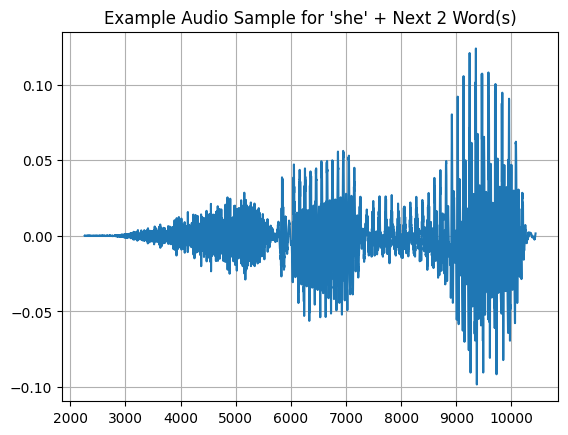

In [468]:
# DEFINE LENGTH OF SEQUENCE
n_words = 3

# Divide each signal into words
word_audios = []
word_starts = []
word_ends = []

for i in range(len(words)):
  word_table = words[i]
  word_table.columns = ['start_t', 'end_t', 'word']
  audio = samples[i]
  table_word_audios = []
  table_word_starts = []
  table_word_ends = []

  for id_, word in word_table.iterrows():
      # Set up counter
      gap_size = n_words - 1

      start = word_table.iloc[id_,:]['start_t']
      end = word_table.iloc[id_+gap_size,:]['end_t']
      table_word_starts.append(start)
      table_word_ends.append(end)
      table_word_audios.append(audio[start:end])

      if (id_ + n_words) == len(word_table):
        break
  
  word_audios.append(table_word_audios)
  word_starts.append(table_word_starts)
  word_ends.append(table_word_ends)

# Plot a test example
word_id = 0
plt.grid()
plt.plot(np.arange(word_starts[0][word_id], word_ends[0][word_id]), word_audios[0][word_id])
plt.title(f"Example Audio Sample for '{words[0]['word'][word_id]}' + Next {n_words-1} Word(s)")
plt.show()

# Manually extract words from fake sample
Visually from plot

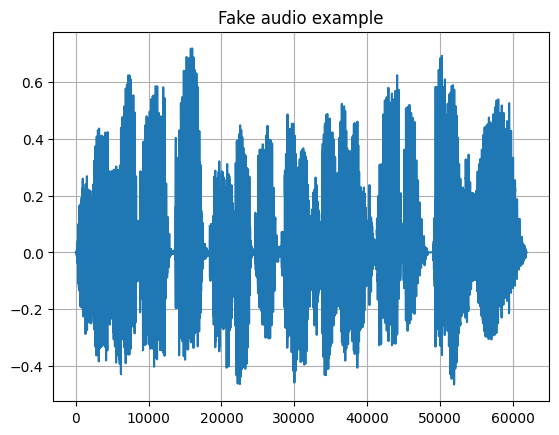

In [469]:
plt.grid()
plt.plot(np.arange(len(anomalous_files[0])), anomalous_files[0])
plt.title(f"Fake audio example")
plt.show()

Estimate manual params - using audacity quick select and playing the section out loud

Note them in seconds then convert using sample rate
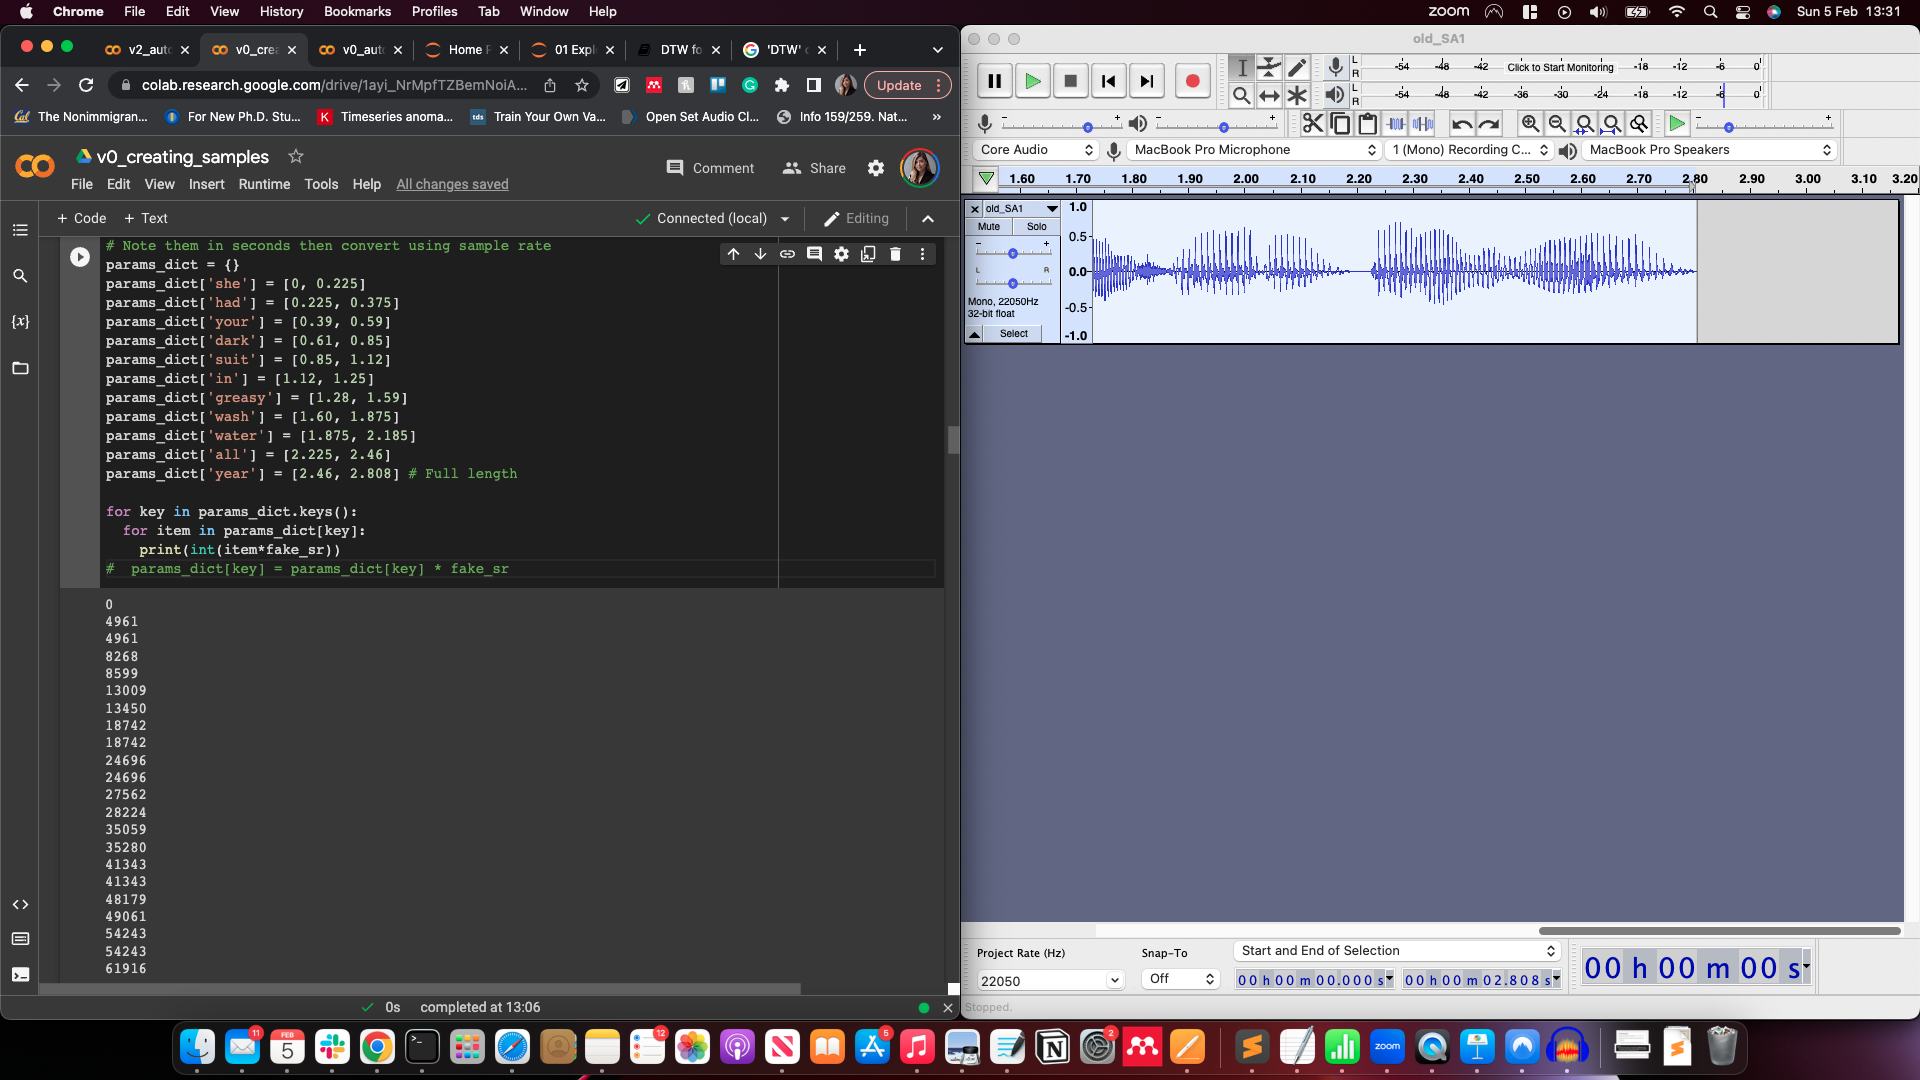

In [470]:
fake_words_tables = []

params_dict = {}
params_dict['she'] = [0, 0.225]
params_dict['had'] = [0.225, 0.375]
params_dict['your'] = [0.39, 0.59]
params_dict['dark'] = [0.61, 0.85]
params_dict['suit'] = [0.85, 1.12]
params_dict['in'] = [1.12, 1.25]
params_dict['greasy'] = [1.28, 1.59]
params_dict['wash'] = [1.60, 1.875]
params_dict['water'] = [1.875, 2.185]
params_dict['all'] = [2.225, 2.46]
params_dict['year'] = [2.46, 2.808] # Full length 

for key in params_dict.keys():
  params_dict[key] = np.array((params_dict[key]))*fake_sr

# Clean the fake words dataframe
fake_words_table = pd.DataFrame(params_dict).T
fake_words_table['2'] = fake_words_table.index
fake_words_table = fake_words_table.reset_index().drop('index', axis = 1)
fake_words_table[0] = fake_words_table[0].astype(int)
fake_words_table[1] = fake_words_table[1].astype(int)

fake_words_tables.append(fake_words_table)
fake_words_tables[0]

,0,1,2
0,0,4961,she
1,4961,8268,had
2,8599,13009,your
3,13450,18742,dark
4,18742,24696,suit
5,24696,27562,in
6,28224,35059,greasy
7,35280,41343,wash
8,41343,48179,water
9,49061,54243,all


### Chop up fake audios to words level

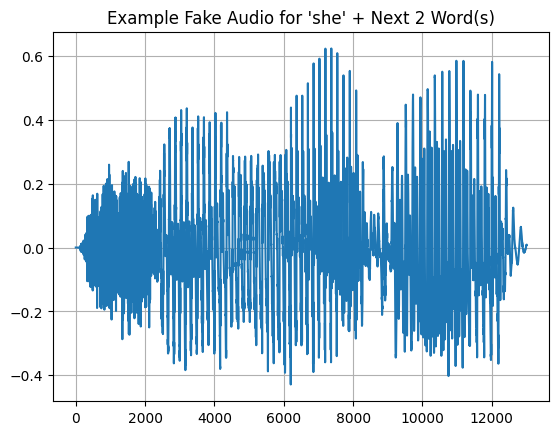

In [471]:
# Divide each signal into words (we retain the same n_words as above)
fake_word_audios = []
fake_word_starts = []
fake_word_ends = []

for i in range(len(fake_words_tables)):
  word_table = fake_words_tables[i]
  word_table.columns = ['start_t', 'end_t', 'word']
  audio = anomalous_files[i]
  table_word_audios = []
  table_word_starts = []
  table_word_ends = []

  for id_, word in word_table.iterrows():
      # Set up counter
      gap_size = n_words-1

      start = word_table.iloc[id_,:]['start_t']
      end = word_table.iloc[id_+gap_size,:]['end_t']

      table_word_starts.append(start)
      table_word_ends.append(end)
      table_word_audios.append(audio[start:end])

      if (id_ + n_words) == len(word_table):
        break
  
  fake_word_audios.append(table_word_audios)
  fake_word_starts.append(table_word_starts)
  fake_word_ends.append(table_word_ends)

# Plot a test example
word_id = 0
plt.grid()
plt.plot(np.arange(fake_word_starts[0][word_id], fake_word_ends[0][word_id]), fake_word_audios[0][word_id])
plt.title(f"Example Fake Audio for '{words[0]['word'][word_id]}' + Next {n_words-1} Word(s)")
plt.show()

# Scaling & Interpolation



## Single Sample - item one, 'she' + n words

<b>Normalising data:

In [472]:
norm_word_audios = []
for i in range(len(word_audios)):
  sample = word_audios[i][0] # I'th participant, *0th* word for all ('she' + n_words)
  max_abs = np.max(np.abs(sample))
  norm_sample = sample/max_abs
  norm_word_audios.append(norm_sample)
print(norm_word_audios[0])

# Repeat for fake
norm_fake_word_audios = []
for i in range(len(fake_word_audios)):
  sample = fake_word_audios[i][0] # I'th participant, *0th* word for all ('she' + n_words)
  max_abs = np.max(np.abs(sample))
  norm_sample = sample/max_abs
  norm_fake_word_audios.append(norm_sample)
print(norm_fake_word_audios[0])

[0.00082847 0.00049486 0.00045281 ... 0.00812671 0.01035008 0.0130613 ]
[0.         0.         0.         ... 0.01444521 0.01459211 0.0135638 ]


In [473]:
# Testing with just one word
she_real = [norm_word_audios[i] for i in range(len(norm_word_audios))]
she_fake = norm_fake_word_audios[0]

mixed_list = she_real + [she_fake]
median_len = np.median([len(item) for item in mixed_list])

actions = []

for i in range(len(mixed_list)):
    sample = mixed_list[i]
    
    if len(sample) < median_len:
        actions.append('extrapolate')
    elif len(sample) == median_len:
        actions.append('none')
        median_id = i
    else:
        actions.append('interpolate')

**Plot the median length audio file with normalisation:**

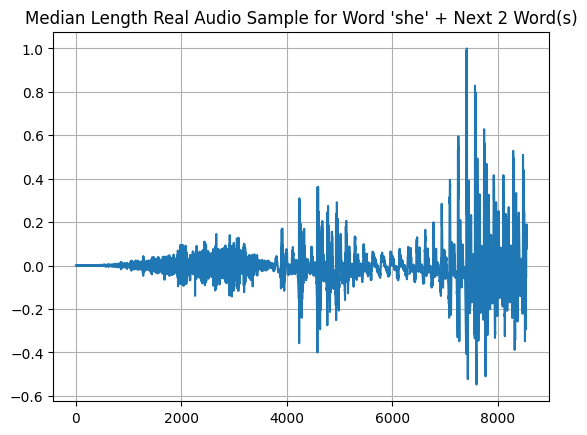

In [474]:
plt.grid()
plt.plot(np.arange(median_len), norm_word_audios[median_id])
plt.title(f"Median Length Real Audio Sample for Word '{words[0]['word'][0]}' + Next {n_words-1} Word(s)")
plt.show()

### Perform the re-scaling



In [475]:
from scipy import interpolate

resampled_audios = []
for i in range(len(mixed_list)):

    # Median length array 
    template = mixed_list[median_id]

    # Other array (to be stretched or shrunk)
    query = mixed_list[i] 

    if actions[i] == 'interpolate':
        f = interpolate.interp1d(np.arange(0, len(query)), query)
        resampled_query = f(np.linspace(0.0, len(query)-1, len(template)))

    elif actions[i] == 'none':
        resampled_query = query

    else:

        f = interpolate.interp1d(np.arange(0, len(query)), query, fill_value='extrapolate')
        resampled_query = f(np.linspace(0.0, len(query)-1, len(template)))

    resampled_audios.append(resampled_query)

# Test the lengths
print(len(resampled_audios[0]))
print(len(resampled_audios[400]))
print(len(resampled_audios[53]))

8550
8550
8550


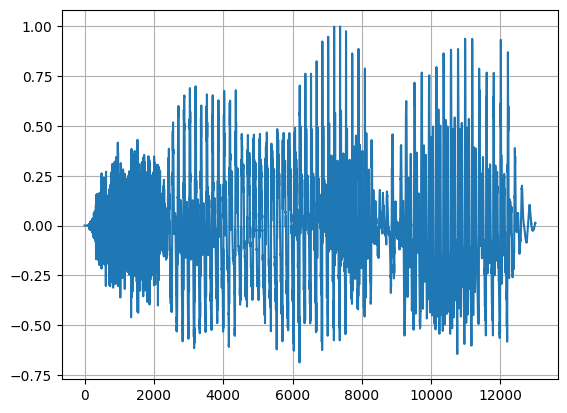

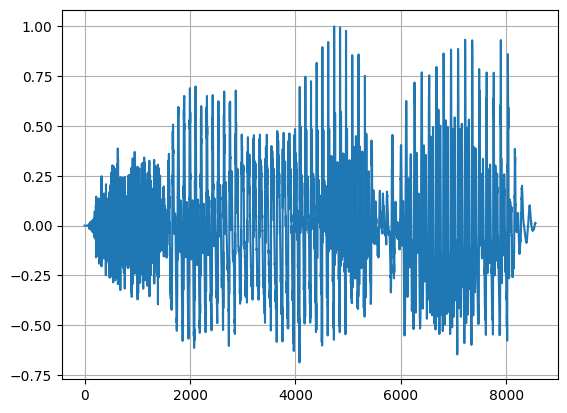

In [476]:
i = -1
plt.grid()
plt.plot(np.arange(len(mixed_list[i])), mixed_list[i])
plt.title(f"")
plt.show()

plt.grid()
plt.plot(np.arange(len(resampled_audios[i])), resampled_audios[i])
plt.title(f"")
plt.show()

In [477]:
# Save out to file to test a real and fake 
import soundfile as sf

filename = 'median_length_original'
item = template
sf.write(f'XX Data/output_test_files/{filename}.wav', item, real_sr)

filename = 'resampled_real_test'
item = mixed_list[0]
sf.write(f'XX Data/output_test_files/{filename}.wav', item, real_sr)

filename = 'resampled_fake'
item = resampled_audios[-1]
sf.write(f'XX Data/output_test_files/{filename}.wav', item, fake_sr)

# New Approach: Sentence Level
Use whole sentence as we think TIMIT word labels are inaccurate.

### Normalise:

[-8.8368091e-05 -1.3302237e-03 -1.1744767e-03 ... -2.0755529e-04
  7.9393823e-04  0.0000000e+00]
[0. 0. 0. ... 0. 0. 0.]


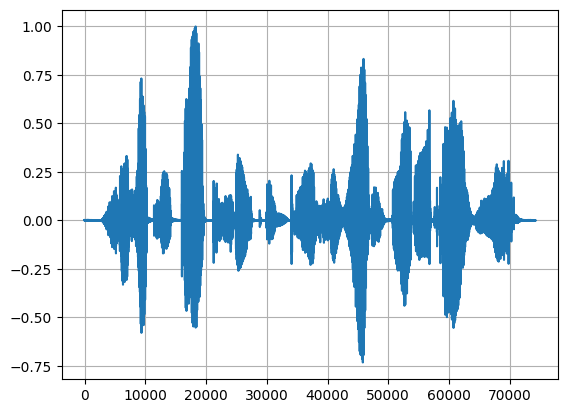

In [6]:
norm_sentence_audios = []

for i in range(len(sentence_audios)):
  sample = sentence_audios[i] # I'th participant
  max_abs = np.max(np.abs(sample))
  norm_sample = sample/max_abs
  norm_sentence_audios.append(norm_sample)
print(norm_sentence_audios[0])

# Repeat for fake
norm_fake_sentence_audios = []
for i in range(len(fake_sentence_audios)):
  sample = fake_sentence_audios[i] # I'th participant
  max_abs = np.max(np.abs(sample))
  norm_sample = sample/max_abs
  norm_fake_sentence_audios.append(norm_sample)
print(norm_fake_sentence_audios[0])

plt.grid()
plt.plot(np.arange(len(norm_sentence_audios[0])), norm_sentence_audios[0])
plt.title(f"")
plt.show()

### Truncate silence at ends:

0
100
0.0003048975

1000
1100
0.00029140533

2000
2100
0.00021260139



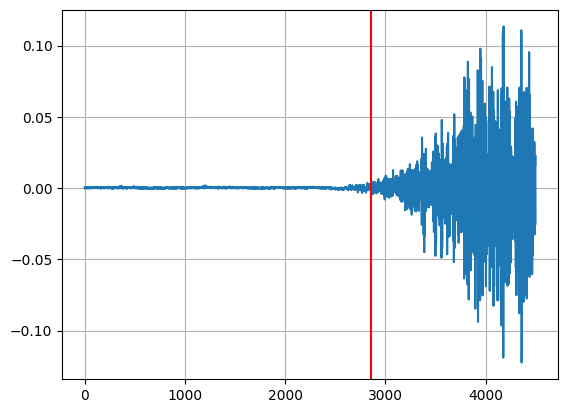

In [480]:
# Caulcuating the correct threshold for 'silence'
n = 100 
i = 400

threshold = 0.0020 # Set via manual inspection of graph below

for j in range(len(norm_sentence_audios[i][0:5000])):
    roll_average = np.mean(np.abs(norm_sentence_audios[i][j:j+n]))
    if j % 1000 == 0:
      print(j)
      print(j+n)
      print(roll_average)
      print()
    if roll_average > threshold:
      truncation_id = j
      break

# NOTE: we assume 'silence' as less than threshold rolling average
plt.grid()
plt.plot(np.arange(len(norm_sentence_audios[i][0:4500])), norm_sentence_audios[i][0:4500])
plt.title(f"")
plt.axvline(x=truncation_id, color='r', linestyle='-')
plt.show()

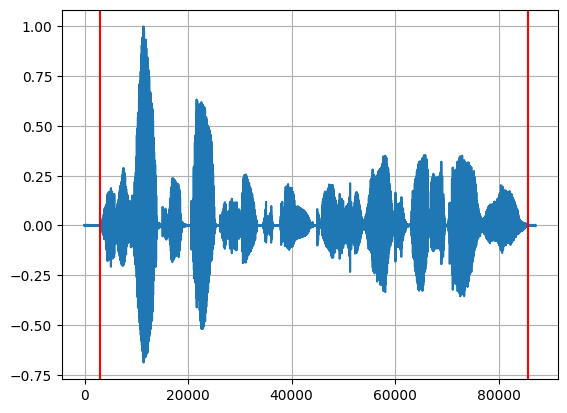

In [481]:
# Checking thresholding works

n = 100 # Rolling window size, set manually through experimentation above
threshold = 0.0020 # Set via manual inspection of graph above

for i in range(len(norm_sentence_audios[0:2])):
    for j in range(len(norm_sentence_audios[i])):
        roll_average = np.mean(np.abs(norm_sentence_audios[i][j:j+n]))
        if roll_average > threshold:
            truncation_id_start = j
            break

    for j in reversed(range(len(norm_sentence_audios[i]))):
        roll_average = np.mean(np.abs(norm_sentence_audios[i][j-n:j]))
        if roll_average > threshold:
            truncation_id_end = j-n
            break

plt.grid()
plt.plot(np.arange(len(norm_sentence_audios[i])), norm_sentence_audios[i])
plt.title(f"")
plt.axvline(x=truncation_id_start, color='r', linestyle='-')
plt.axvline(x=truncation_id_end, color='r', linestyle='-')
plt.show()

In [482]:
# Perform truncation
n = 100 # Rolling window size, set manually through experimentation above
threshold = 0.0020 # Set via manual inspection of graph above

truncated_norm_sentence_audios = []
truncated_norm_fake_sentence_audios = []

for i in range(len(norm_sentence_audios)):
    for j in range(len(norm_sentence_audios[i])):
        roll_average = np.mean(np.abs(norm_sentence_audios[i][j:j+n]))
        if roll_average > threshold:
            truncation_id_start = j
            break

    for j in reversed(range(len(norm_sentence_audios[i]))):
        roll_average = np.mean(np.abs(norm_sentence_audios[i][j-n:j]))
        if roll_average > threshold:
            truncation_id_end = j-n
            break
    truncated_norm_sentence_audios.append(norm_sentence_audios[i][truncation_id_start:truncation_id_end])

for i in range(len(norm_fake_sentence_audios)):
    for j in range(len(norm_fake_sentence_audios[i])):
        roll_average = np.mean(np.abs(norm_fake_sentence_audios[i][j:j+n]))
        if roll_average > threshold:
            truncation_id_start = j
            break

    for j in reversed(range(len(norm_fake_sentence_audios[i]))):
        roll_average = np.mean(np.abs(norm_fake_sentence_audios[i][j-n:j]))
        if roll_average > threshold:
            truncation_id_end = j-n
            break
    truncated_norm_fake_sentence_audios.append(norm_fake_sentence_audios[i][truncation_id_start:truncation_id_end])

print(len(truncated_norm_sentence_audios))
print(len(truncated_norm_fake_sentence_audios))

462
1


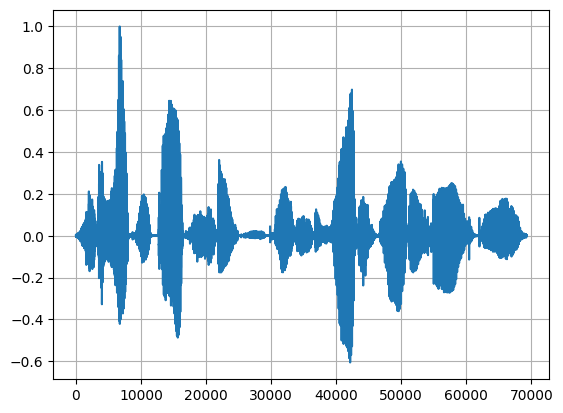

In [483]:
# Check with random signals
i = 230

plt.grid()
plt.plot(np.arange(len(truncated_norm_sentence_audios[i])), truncated_norm_sentence_audios[i])
plt.title(f"")
plt.show()

### Resample:

In [484]:
mixed_list = []

for item in truncated_norm_sentence_audios:
  mixed_list.append(item)

for item in truncated_norm_fake_sentence_audios:
   mixed_list.append(item)

median_len = np.median([len(item) for item in mixed_list])

actions = []

for i in range(len(mixed_list)):
    sample = mixed_list[i]
    
    if len(sample) < median_len:
        actions.append('extrapolate')
    elif len(sample) == median_len:
        actions.append('none')
        median_id = i
    else:
        actions.append('interpolate')

In [485]:
from scipy import interpolate

resampled_audios = []
for i in range(len(mixed_list)):

    # Median length array 
    template = mixed_list[median_id]

    # Other array (to be stretched or shrunk)
    query = mixed_list[i] 

    if actions[i] == 'interpolate':
        f = interpolate.interp1d(np.arange(0, len(query)), query)
        resampled_query = f(np.linspace(0.0, len(query)-1, len(template)))

    elif actions[i] == 'none':
        resampled_query = query

    else:

        f = interpolate.interp1d(np.arange(0, len(query)), query, fill_value='extrapolate')
        resampled_query = f(np.linspace(0.0, len(query)-1, len(template)))

    resampled_audios.append(resampled_query)

# Test the lengths
print(len(resampled_audios[0]))
print(len(resampled_audios[400]))
print(len(resampled_audios[53]))

68496
68496
68496


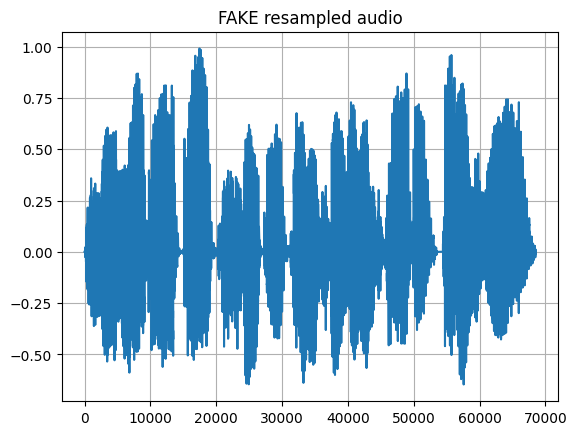

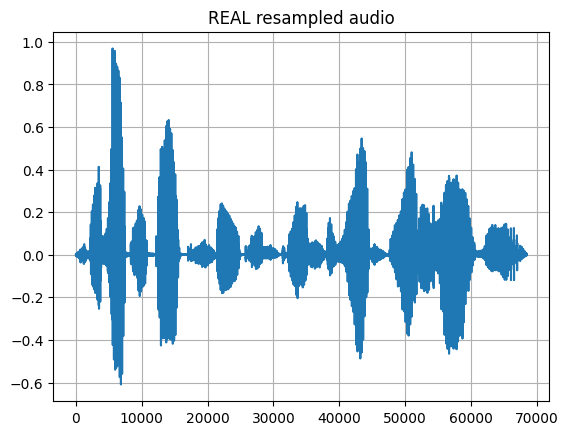

In [486]:
i = -1

plt.grid()
plt.plot(np.arange(len(resampled_audios[i])), resampled_audios[i])
plt.title(f"FAKE resampled audio")
plt.show()

i = 200

plt.grid()
plt.plot(np.arange(len(resampled_audios[i])), resampled_audios[i])
plt.title(f"REAL resampled audio")
plt.show()

In [487]:
# Save out to file to test a real and fake 
import soundfile as sf

filename = 'example_real_original'
item = norm_sentence_audios[200]
sf.write(f'XX Data/output_test_files/{filename}.wav', item, real_sr)

filename = 'example_real_resampled'
item = resampled_audios[200]
sf.write(f'XX Data/output_test_files/{filename}.wav', item, real_sr)

filename = 'example_fake_original'
item = norm_fake_sentence_audios[0]
sf.write(f'XX Data/output_test_files/{filename}.wav', item, fake_sr)

filename = 'example_fake_resampled'
item = resampled_audios[-1]
sf.write(f'XX Data/output_test_files/{filename}.wav', item, fake_sr)

# Write out all the REAL engineered samples

In [488]:
def process(audios):

    # Normalise
    norm_sentence_audios = []

    for i in range(len(audios)):
        sample = audios[i] # I'th participant
        max_abs = np.max(np.abs(sample))
        norm_sample = sample/max_abs
        norm_sentence_audios.append(norm_sample)

    # Truncate - for fakes this will require knowledge of the truncated lengths for the real audios. Params previously set above.
    n = 100 
    threshold = 0.0020 

    truncated_norm_sentence_audios = []

    for i in range(len(norm_sentence_audios)):
        for j in range(len(norm_sentence_audios[i])):
            roll_average = np.mean(np.abs(norm_sentence_audios[i][j:j+n]))
            if roll_average > threshold:
                truncation_id_start = j
                break

        for j in reversed(range(len(norm_sentence_audios[i]))):
            roll_average = np.mean(np.abs(norm_sentence_audios[i][j-n:j]))
            if roll_average > threshold:
                truncation_id_end = j-n
                break
        truncated_norm_sentence_audios.append(norm_sentence_audios[i][truncation_id_start:truncation_id_end])

    # Resample
    # First, handle median calc for phrases with even number of samples
    if len(truncated_norm_sentence_audios) % 2 == 0:
        median_len = np.median([len(item) for item in truncated_norm_sentence_audios+['NaN']])
    else:
        median_len = np.median([len(item) for item in truncated_norm_sentence_audios])

    actions = []
    for i in range(len(truncated_norm_sentence_audios)):
        sample = truncated_norm_sentence_audios[i]
        
        if len(sample) < median_len:
            actions.append('extrapolate')
        elif len(sample) == median_len:
            actions.append('none')
            median_id = i
        else:
            actions.append('interpolate')

    resampled_audios = []
    for i in range(len(truncated_norm_sentence_audios)):
        template = truncated_norm_sentence_audios[median_id]

        # Other array (to be stretched or shrunk)
        query = truncated_norm_sentence_audios[i] 

        if actions[i] == 'interpolate':
            f = interpolate.interp1d(np.arange(0, len(query)), query)
            resampled_query = f(np.linspace(0.0, len(query)-1, len(template)))
        elif actions[i] == 'none':
            resampled_query = query
        else:
            f = interpolate.interp1d(np.arange(0, len(query)), query, fill_value='extrapolate')
            resampled_query = f(np.linspace(0.0, len(query)-1, len(template)))

        resampled_audios.append(resampled_query)

    if len(resampled_audios) != 1:
        print(f'Normalisation check: max amplitude = {max(norm_sentence_audios[0])}')
        print(f'Original truncated lengths: Length 1: {len(truncated_norm_sentence_audios[0])}, length 2: {len(truncated_norm_sentence_audios[3])}')
        print(f'resample_check: {len(resampled_audios[0])}, {len(resampled_audios[1])}')
        print()

    processed_audios = resampled_audios

    return processed_audios
    

In [10]:
wav_files = sorted([file for file in os.listdir(inputs['wav_files']) if not file.startswith('.')])
real_sr = [ingest_audio(inputs, file)[1] for file in wav_files[0:2]][0]

In [417]:
unique_phrases = list(set([item.split('.')[0].split('_')[1] for item in wav_files]))

debug_counter = 0

for phrase in unique_phrases:

    # Obtain all participant samples for the same phrase
    phrase_files = [item for item in wav_files if phrase in item]

    # Ingest audios
    samples = [ingest_audio(inputs, file)[0] for file in phrase_files]

    if len(samples) != 1:
      print(phrase)
      print(len(samples))
    
    # Process them
    processed_samples = process(samples)

    # Write to appropriate file
    folder_path = inputs['processed_output_files'] + '/' + phrase
    os.mkdir(folder_path)
    os.mkdir(folder_path + '/real')

    for i in range(len(phrase_files)):
        phrase_file = phrase_files[i]
        phrase_audio = processed_samples[i]
        #sf.write(f'{folder_path}/real/{phrase_file}', phrase_audio, real_sr)
    
    debug_counter = debug_counter + 1

SX376
7
Normalisation check: max amplitude = 1.0
Original truncated lengths: Length 1: 69160, length 2: 58851
resample_check: 59092, 59092

SX402
7
Normalisation check: max amplitude = 1.0
Original truncated lengths: Length 1: 63696, length 2: 47419
resample_check: 63666, 63666

SX62
7
Normalisation check: max amplitude = 1.0
Original truncated lengths: Length 1: 54345, length 2: 59686
resample_check: 57469, 57469

SX61
7
Normalisation check: max amplitude = 1.0
Original truncated lengths: Length 1: 73323, length 2: 49248
resample_check: 67712, 67712

SX122
7
Normalisation check: max amplitude = 1.0
Original truncated lengths: Length 1: 70394, length 2: 73767
resample_check: 72216, 72216

SX218
7
Normalisation check: max amplitude = 1.0
Original truncated lengths: Length 1: 68731, length 2: 61364
resample_check: 61258, 61258

SX125
7
Normalisation check: max amplitude = 1.0
Original truncated lengths: Length 1: 47095, length 2: 54260
resample_check: 47095, 47095

SX179
7
Normalisation 

In [419]:
debug_counter 

1718

# Gather more fake examples for each phrase from ElevenLabs API

In [5]:
import requests
import os
import json
from pydub import AudioSegment

#import params
with open('XX Data/config.yaml', 'r') as file:
    inputs = yaml.safe_load(file)

xi_api_key = inputs['eleven_labs_api_key']

#get the voice IDs
url = 'https://api.elevenlabs.io/v1/voices'
headers = {'accept':'application/json',
           'xi-api-key':xi_api_key}

r = requests.get(url, headers=headers)
voice_data = r.json()['voices']
voice_ids = dict([(voice['name'], voice['voice_id']) for voice in voice_data])

print(voice_ids.keys())

dict_keys(['Rachel', 'Domi', 'Bella', 'Antoni', 'Elli', 'Josh', 'Arnold', 'Adam', 'Sam', 'Obama', 'Biden'])


In [8]:
def generate_deepfake(voice_id, text, output_file, api_key, sr):
    
    headers = {
        'accept': 'audio/mpeg',
        'xi-api-key': api_key,
        'Content-Type': 'application/json'
    }

    #data = '{"text": "Eleven Labs has a made a voice cloning AI that will do a good job at modeling Biden"}'
    data = f'{{"text": "{text}"}}'

    r = requests.post(f'https://api.elevenlabs.io/v1/text-to-speech/{voice_id}', headers=headers, data=data)
    
    with open(output_file, 'wb') as f:
        f.write(r.content)
        f.close()
    

In [11]:
# Obtain word files list
word_files = sorted([file for file in os.listdir(inputs['word_files']) if not file.startswith('.')])
unique_phrases = list(set([item.split('.')[0].split('_')[1] for item in wav_files]))

for phrase in unique_phrases:

    # Obtain all participant samples for the same phrase
    phrase_word_files = [item for item in word_files if phrase in item]

    # Generate text
    words = [pd.read_csv(f"{inputs['word_files']}/{file}", sep=" ", header=None) for file in phrase_word_files]
    word_table = words[0]
    word_table.columns = ['start_t', 'end_t', 'word']

    text = str()
    for word in word_table['word']:
        text = text + ' ' + word

    # Loop through the generation voices
    output_folder = inputs['processed_output_files'] + '/' + phrase
    os.mkdir(output_folder + '/fake')

    for voice_id in voice_ids.keys():
        output_file = output_folder + '/fake/' + voice_id + '_' + phrase + '.mpeg'
        
        # Generates the MPEG as the API will only return MPEG
        #generate_deepfake(voice_ids[voice_id], text, output_file, xi_api_key, real_sr)

    debug_counter = debug_counter + 1

FileExistsError: ignored

Convert to wav and resample 

In [12]:
failed_index = [i for i in range(len(unique_phrases)) if 'SI1161' in unique_phrases[i]]
print(failed_index[0])

412


In [504]:
print()

['SI985', 'SI696', 'SI2021', 'SI1297', 'SI1188', 'SX125', 'SI1798', 'SI520', 'SX179', 'SI1132', 'SI791', 'SI2306', 'SI1393', 'SI1889', 'SI540', 'SX231', 'SI667', 'SI709', 'SI609', 'SI1582', 'SI1305', 'SI1295', 'SI2181', 'SX176', 'SI1380', 'SI1545', 'SX445', 'SI1973', 'SI1465', 'SI1824', 'SI1605', 'SI1678', 'SI1456', 'SI1072', 'SI1343', 'SI1569', 'SI598', 'SI1742', 'SI1572', 'SI849', 'SI787', 'SI1979', 'SX93', 'SX141', 'SI2091', 'SI2311', 'SI1914', 'SI571', 'SI1854', 'SI1349', 'SX420', 'SI1165', 'SI807', 'SI1167', 'SI723', 'SI1173', 'SI1331', 'SX450', 'SI578', 'SI495', 'SX438', 'SI1056', 'SI1960', 'SI2238', 'SI1328', 'SI1874', 'SI1740', 'SI1514', 'SI474', 'SX301', 'SI1321', 'SI951', 'SI1351', 'SI1257', 'SX254', 'SI1536', 'SX297', 'SI834', 'SI514', 'SI1387', 'SI657', 'SI1080', 'SI2240', 'SI2020', 'SI1862', 'SI2232', 'SI509', 'SI2097', 'SX85', 'SI1807', 'SX225', 'SI2047', 'SX357', 'SI1194', 'SI467', 'SI1142', 'SI1017', 'SI1565', 'SI1784', 'SI1322', 'SI1570', 'SX276', 'SX232', 'SI1427', 'S

In [ ]:
# FOR ONES THAT DIDNT WORK - to run later - augment this to check if the file contains error or not 
failed_index = [i for i in range(len(unique_phrases)) if 'SI1161' in unique_phrases[i]]
unique_phrases = unique_phrases[failed_index[0] + 1:]

for phrase in unique_phrases:

    # Obtain all participant samples for the same phrase
    phrase_word_files = [item for item in word_files if phrase in item]

    # Generate text
    words = [pd.read_csv(f"{inputs['word_files']}/{file}", sep=" ", header=None) for file in phrase_word_files]
    word_table = words[0]
    word_table.columns = ['start_t', 'end_t', 'word']

    text = str()
    for word in word_table['word']:
        text = text + ' ' + word

    # Loop through the generation voices
    output_folder = inputs['processed_output_files'] + '/' + phrase
    # EXTRA STEP: delete the buggy files
    os.rmdir(output_folder + '/fake')
    os.mkdir(output_folder + '/fake')

    for voice_id in voice_ids.keys():
        output_file = output_folder + '/fake/' + voice_id + '_' + phrase + '.mpeg'
        
        # Generates the MPEG as the API will only return MPEG
        generate_deepfake(voice_ids[voice_id], text, output_file, xi_api_key, real_sr)

    debug_counter = debug_counter + 1

In [ ]:
# CONVERT THE ONES THAT DID WORK
input_folder = inputs['processed_output_files']
#input_folder = 'XX Data/WAV CONVERSION TEST/input'
failed_generations = []
failed_files = []
already_converted = []
debug_counter = -1

for folder in [item for item in os.listdir(input_folder) if not item.startswith('.')]:
    for file in [item for item in os.listdir(f'{input_folder}/{folder}/fake') if not item.startswith('.')]:
        debug_counter = debug_counter + 1
        file_path = os.path.join(input_folder, folder, 'fake', file)   
        if '.DS_Store' in file:
            continue
        try:
            input_audio = os.path.join(input_folder, folder, 'fake', file)
            output_audio = os.path.join(input_folder, folder, 'fake', file.replace('.mpeg', '.wav'))
            import_audio = AudioSegment.from_file(input_audio)
            import_audio.export(output_audio, format='wav')
            os.remove(input_audio)
            if debug_counter % 50 == 0:
                    print(f'Item {debug_counter}: successfully converted {input_audio}')
        except:
            # If already converted:
            if '.wav.' in input_audio:
              already_converted.append(input_audio)
              continue

            # If the audio doesnt exist yet... 
            else:
                failed_generations.append(folder)
                failed_files.append(input_audio)

                if debug_counter % 50 == 0:
                    print(f'Item {debug_counter}, phrase {folder}: previously failed audio {failed_generations[-1]}, file_id {failed_files[-1]}')

            continue

print(len(set(failed_generations)))

Item 0, phrase SA1: previously failed audio SA1, file_id /Volumes/2022_OTHER/TIMIT processed/SA1/fake/Adam_SA1.mpeg
Item 50, phrase SI1007: previously failed audio SI1007, file_id /Volumes/2022_OTHER/TIMIT processed/SI1007/fake/Elli_SI1007.mpeg
Item 100, phrase SI1016: previously failed audio SI1016, file_id /Volumes/2022_OTHER/TIMIT processed/SI1016/fake/Antoni_SI1016.mpeg
Item 150, phrase SI1021: previously failed audio SI1021, file_id /Volumes/2022_OTHER/TIMIT processed/SI1021/fake/Josh_SI1021.mpeg
Item 200, phrase SI1028: previously failed audio SI1028, file_id /Volumes/2022_OTHER/TIMIT processed/SI1028/fake/Arnold_SI1028.mpeg
Item 250, phrase SI1035: previously failed audio SI1035, file_id /Volumes/2022_OTHER/TIMIT processed/SI1035/fake/Obama_SI1035.mpeg
Item 300, phrase SI1045: previously failed audio SI1045, file_id /Volumes/2022_OTHER/TIMIT processed/SI1045/fake/Bella_SI1045.mpeg
Item 350, phrase SI1049: previously failed audio SI1049, file_id /Volumes/2022_OTHER/TIMIT processe

In [47]:
# NOW: produce resampled versions
for folder in [item for item in os.listdir(input_folder) if not item.startswith('.')]:
    os.mkdir(f'{input_folder}/{folder}/fake_processed')
    for file in [item for item in os.listdir(f'{input_folder}/{folder}/fake') if not item.startswith('.')]:
      # Ingest audio
      # Preprocess it
      # Write out to 
      

['XX Data/WAV CONVERSION TEST/input/SI496/fake/Biden_SI496.mpeg']

In [39]:
# Convert to .wav and run through whole processing pipeline 
#input_folder = inputs['processed_output_files']
#input_folder = 'XX Data/WAV CONVERSION TEST/input'
#output_folder = inputs['processed_output_files']
#output_folder = 'XX Data/WAV CONVERSION TEST/input'

for folder in [item for item in os.listdir(input_folder) if not item.startswith('.')]:
    print(folder)
    for file in [item for item in os.listdir(f'{input_folder}/{folder}/fake') if not item.startswith('.')]:
        file_path = os.path.join(input_folder, folder, 'fake', file)   
        if '.DS_Store' in file:
            continue
        try:
            import_audio = AudioSegment.from_file(os.path.join(input_folder, folder, 'fake', file))
            import_audio.export(os.path.join(output_folder, file.replace('.mpeg', '.wav')), format='wav')
        except:

            # Re-generate deepfake
            phrase = folder

             # Obtain all participant samples for the same phrase
            phrase_word_files = [item for item in word_files if phrase in item]

            # Generate text
            words = [pd.read_csv(f"{inputs['word_files']}/{file}", sep=" ", header=None) for file in phrase_word_files]
            word_table = words[0]
            word_table.columns = ['start_t', 'end_t', 'word']

            text = str()
            for word in word_table['word']:
                text = text + ' ' + word

            # Loop through the generation voices
            #output_folder = inputs['processed_output_files'] + '/' + phrase

            for voice_id in voice_ids.keys():
                output_file = os.path.join(output_folder, phrase, 'fake', voice_id + '_' + phrase + '.mpeg')
                
                # Generates the MPEG as the API will only return MPEG
                generate_deepfake(voice_ids[voice_id], text, output_file, xi_api_key, real_sr)

            # Now: try again to save as wav files
            try:
                import_audio = AudioSegment.from_file(os.path.join(input_folder, folder, 'fake', file))
                import_audio.export(os.path.join(output_folder, file.replace('.mpeg', '.wav')), format='wav')
            except:
              print(f"failed at: {os.path.join(input_folder, folder, 'fake', file.replace('.mpeg', '.wav'))}")



SI496


KeyboardInterrupt: ignored

### Calculate ratio of silence as a model for cadence:

In [385]:
test = np.arange(0, 28, 1)
round(np.median(test))

14

### Plot distributions of real vs. fake:

## Also to explore: intonation

# Try words approach but with phonemes instead (using a chain of like 10 phonemes)